# **Photovoltaic panel segmentation on building facades**

Ayca Duran*, Pedram Mirabian, Panagiotis Karapiperis, Christoph Waibel,
Bernd Bickel and Arno Schlueter

## Step 4: Model Training - MaskrCNN

This notebook covers the training and evaluation of the MaskRCNN models using the Detectrion2 platform. The existing values in this notebook are related to the two best performing models featured in the paper.

In [3]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/', force_remount= False)
base_directory = Path('/content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Setup

In [4]:
#@title installation & imports

import sys
import os
import json
import pickle
import distutils.core



# Check if GPU is available
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!nvidia-smi

# Detectron2 (needs download on Google Colab)
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

#
import detectron2
from detectron2 import model_zoo
#
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.engine.hooks import HookBase
#
from detectron2.checkpoint import DetectionCheckpointer
#
from detectron2.evaluation import inference_context
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
#
from detectron2.config import get_cfg
#
import detectron2.utils
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.logger import log_every_n_seconds
setup_logger()
import detectron2.utils.comm as comm
#
from detectron2 import structures

# Logging
import time
import datetime
import logging
from tqdm import tqdm

# Required libraries
import csv
import numpy as np
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import cv2
from pycocotools import mask as mask_utils
import gc
import warnings

# PyTorch (pre-installed on Google Colab)
import torch
from torch.utils.data import Dataset, DataLoader
!nvcc --version
TORCH_VERSION = (torch.__version__)
print("torch: ", TORCH_VERSION)
print("detectron2:", detectron2.__version__)

Fri Oct 10 13:47:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [35]:
#@title paths
dataset_dir = f"{base_directory}/datasets/2_Stratified_Augmented"
trained_models_folder = f"{base_directory}/trained_models"
eval_folder = f"{base_directory}/evaluation"
mask_save_dir = f"{base_directory}/masks"
metrics_save_dir = f"{base_directory}/metrics"

### Dataset Loading

>>> split train with 5789 images
>>> split valid with 101 images
>>> split test with 105 images
[10/10 13:48:03 d2.data.datasets.coco]: Loading /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/datasets/2_Stratified_Augmented/train/_annotations_case2.coco.json takes 3.01 seconds.
WARNING [10/10 13:48:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 13:48:03 d2.data.datasets.coco]: Loaded 5789 images in COCO format from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/datasets/2_Stratified_Augmented/train/_annotations_case2.coco.json
>>> dataset train - showing 5 out of 5789...
WARNING [10/10 13:48:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 13:48:09 d2.data.datasets.coco]: Loaded 101 images in COCO format from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/datasets/2_Stratified_Augmented/val

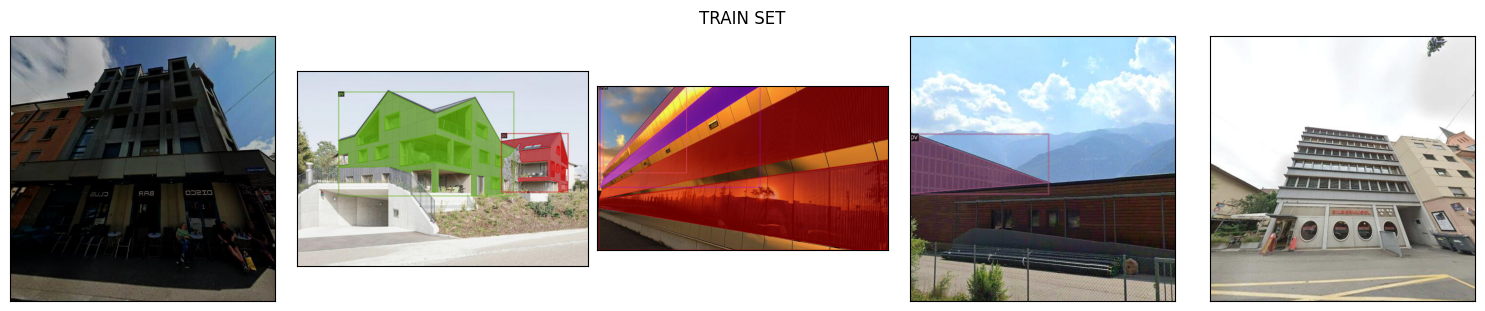

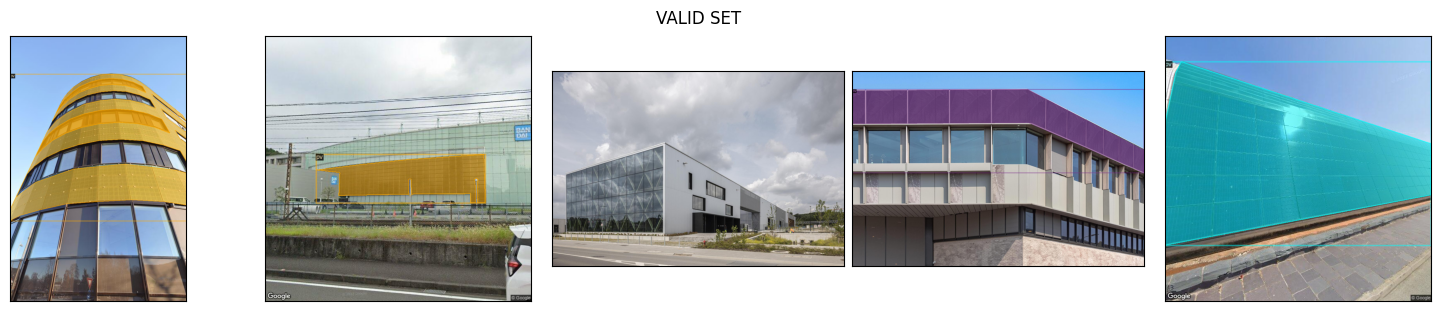

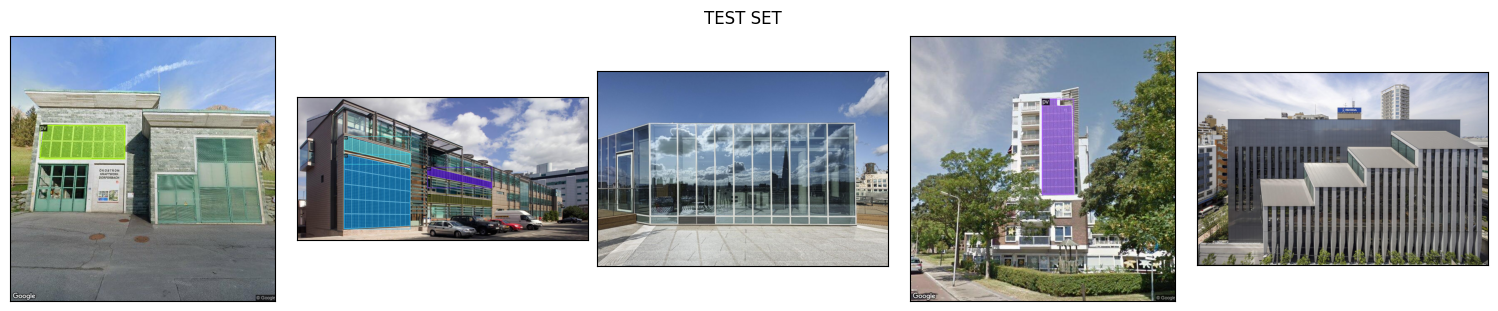

In [6]:
#@title load dataset

'''
Change the select value below to select the dataset. The options are as follows:
[i] Stratification      Augmentation            Includes    (#train, valid, test)
------------------------------------------------------------------------------------
[5] Stratified,         Augmented data,         PV+NonPV    (5768,  101,    105) m7
'''

#@title paths
for split in ["train", "valid", "test"]:
    try:
        MetadataCatalog.remove(split)
    except:
        pass
    try:
        DatasetCatalog.remove(split)
    except:
        pass

    register_coco_instances(split, {}, os.path.join(dataset_dir, split, "_annotations_case2.coco.json"), os.path.join(dataset_dir, split))
    print(f">>> split {split} with {len([item for item in os.listdir(os.path.join(dataset_dir, split)) if item.endswith('.jpg')])} images")

pv_only = False

# visualize samples from each split
for d in ["train", "valid", "test"]:
    dataset_dicts = DatasetCatalog.get(d)
    if pv_only == True:
        dataset_dicts = [item for item in dataset_dicts if len(item.get("annotations", [])) > 0]
        print(f'{len(dataset_dicts)} after filtering null annots...')

    metadata = MetadataCatalog.get(d)

    count = 5
    count = min(count, len(dataset_dicts))
    print(f">>> dataset {d} - showing {count} out of {len(dataset_dicts)}...")

    dim = 3
    cols = 5

    rows = math.ceil(count/cols)
    fig, axs = plt.subplots(rows, cols, figsize= (dim * cols, dim * rows), constrained_layout=True)
    fig.suptitle(f"{d.upper()} SET")

    axs = axs.flat
    for ax in axs:
        ax.tick_params(left = False, right = False ,
                        labelleft = False , labelbottom = False,
                        bottom = False, top = False)
    idx = -1

    for d in dataset_dicts[:count]:
        idx += 1
        img = Image.open(d["file_name"])
        visualizer = Visualizer(img, metadata= metadata, scale=1)
        out = visualizer.draw_dataset_dict(d)
        axs[idx].imshow(out.get_image())

### Model Training

In [7]:
#@title def functions - just run this

def make_next(models_dir, d2model, d2epochs, d2lr, d2bs, d2wd, make= True) -> str:
    # Calculate model iteration
    models_dir_models = [item for item in os.listdir(models_dir) if item[0] != "."]
    if len(models_dir_models) != 0:
        nums = [text.split("_")[0] for text in models_dir_models]

        models = sorted(models_dir_models, key=lambda folder: int(folder.split('_')[0]))
        model_num = int(models[-1].split("_")[0]) + 1
    else:
        model_num = 0

    rem = 3 - len(str(model_num))
    zeroes = "0" * rem
    model_arch = d2model.split("/")[1]
    model_name = f"{zeroes}{model_num}_{model_arch}_{d2epochs}epochs_{d2lr}lr_{d2bs}bs_{d2wd}wd"

    model_dir = os.path.join(models_dir, model_name)
    if make:
        os.makedirs(model_dir, exist_ok=True)
        print(f">>> created model folder at\n{model_dir}")
    else:
        print(f">>> if make == true then folder will be created at\n{model_dir}")

    return model_dir

def model_name_from_num(model_num):
    zeroes = "0" * (3 - len(str(model_num)))
    model_name = None

    for folder in os.listdir(trained_models_folder):
        if folder.split("_")[0] == f"{zeroes}{model_num}":
            model_name = folder
    if model_name == None:
        raise Exception(f"Model with number {model_num} not found in\n{trained_models_folder}")

    return model_name

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_starting = next_iter == 5
        is_final = next_iter == self.trainer.max_iter
        if is_starting or is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

class MeanStdDataset(Dataset):
    def __init__(self, data_dir, pv_only= False, extension= '.jpg', transform= None):
        self.data_dir = data_dir
        self.image_files  = [f for f in os.listdir(data_dir) if f.endswith(extension)]
        if pv_only:
            self.image_files = [f for f in self.image_files if "_gsv_" in f or "_web_" in f]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Open the image and convert to a numpy array, then to a torch tensor.
        image = torch.from_numpy(np.array(PIL.Image.open(os.path.join(self.data_dir, self.image_files[index])), dtype=np.float32))
        # If grayscale, add a channel dimension
        if image.ndim == 2:
            image = image.unsqueeze(-1)
        if self.transform:
            image = self.transform(image)
        return image

def compute_mean_std(dataloader):
    '''
    Compute the per-channel mean and standard deviation for images that may have different sizes.
    This function iterates over images (even if in batches) and computes the running sum, squared sum and total pixel count.
    '''
    total_sum = None
    total_sq_sum = None
    total_pixels = 0

    for batch in tqdm(dataloader):
        # Each batch is a list of images (they are not stacked since their sizes vary)
        for image in batch:
            # image shape: (H, W, C) or (H, W) - but we've handled grayscale in __getitem__
            # Compute per-channel sum and squared sum over height and width.
            # If image is (H, W, C), then summing over dimensions 0 and 1 gives a vector of length C.
            img_sum = torch.sum(image, dim=[0, 1])
            img_sq_sum = torch.sum(image ** 2, dim=[0, 1])
            # Total number of pixels per channel in this image (same for each channel)
            num_pixels = image.shape[0] * image.shape[1]

            if total_sum is None:
                total_sum = img_sum
                total_sq_sum = img_sq_sum
            else:
                total_sum += img_sum
                total_sq_sum += img_sq_sum

            total_pixels += num_pixels

    # The mean is computed by dividing the total per-channel sum by the total number of pixels.
    mean = (total_sum / total_pixels)
    # Standard deviation: sqrt(E[X^2] - (E[X])^2)
    std = torch.sqrt(total_sq_sum / total_pixels - mean ** 2)
    return mean, std

def custom_collate(batch):
    return batch

warnings.filterwarnings("ignore", message="torch.meshgrid: in an upcoming release")

In [8]:
#@title calculate dataset mean std - and the resulting numbers

calculated_values = {
    5: {
        "mean": [122.1287, 129.9507, 136.4666],
        "std": [72.9773, 72.1729, 77.3321]
    }
}

# The above values are calculated using the method below.
# If you want to calculate them again (this might take a while),
# toggle the boolean below:
calc_mean_std = False

if calc_mean_std:
    # calculate mean and std for the selected dataset
    dataset = MeanStdDataset(os.path.join(dataset_dir, "train"), pv_only= pv_only)
    print(f"{len(dataset)} images... (progress bar is batch size 4)")
    train_loader = DataLoader(dataset, batch_size=4, shuffle=False,
                                num_workers=2, collate_fn=custom_collate, pin_memory=True)
    total_mean, total_std = compute_mean_std(train_loader)
    print(f'\nmean (RGB):', total_mean)
    print('std (RGB): ', total_std)
else:
    # use pre-calculated values based on the selected dataset
    total_mean = calculated_values[5]["mean"]
    total_std = calculated_values[5]["std"]

In [10]:
#@title model hyperparameters

cfg = get_cfg()
model = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x"
cfg.merge_from_file(model_zoo.get_config_file(f"{model}.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

'''
all parameters
'''
# EP = 4
# # epochs
# # 4 [x] 25 for unaugmented datasets [x]
# BS = 4
# # batch size
# # 4 [x]
# LR = 0.00005
# # learning rate
# # 0.00001 [x], 0.00005 [x], 0.0001 [x]
# WD = 0.005
# # weight decay
# # 0.0001 [x], 0.0005 [x], 0.001 [x], 0.005 [x]

'''
parameters from best training convergence model
'''
EP = 4
LR = 0.00005
BS = 4
WD = 0.005

'''
parameters from best precision model
'''
EP = 4
LR = 0.00005
BS = 4
WD = 0.005

epochs = EP

cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.INPUT.MAX_SIZE_TRAIN = 850
cfg.INPUT.MAX_SIZE_TEST = 850
cfg.INPUT.RANDOM_FLIP = "none"

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(f"{model}.yaml")
cfg.MODEL.PIXEL_MEAN = total_mean[::-1]
cfg.MODEL.PIXEL_STD = total_std[::-1]

cfg.DATALOADER.NUM_WORKERS = 2
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)

train_dict = DatasetCatalog.get(cfg.DATASETS.TRAIN[0])

cfg.SOLVER.IMS_PER_BATCH = BS
cfg.SOLVER.BASE_LR = LR
cfg.SOLVER.MAX_ITER = (len(train_dict) // cfg.SOLVER.IMS_PER_BATCH) * EP
cfg.SOLVER.WEIGHT_DECAY = WD

cfg.TEST.EVAL_PERIOD = 400

print(f">>> training on {len(train_dict)} images ... {EP} epochs ... {cfg.SOLVER.MAX_ITER} iterations.")
model_dir = make_next(trained_models_folder,
                      model,
                      epochs, cfg.SOLVER.BASE_LR, cfg.SOLVER.IMS_PER_BATCH, cfg.SOLVER.WEIGHT_DECAY,
                      make= False) # so it doesn't create the folder yet, but shows what i will create

cfg.OUTPUT_DIR = model_dir

WARNING [10/10 14:01:46 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/10 14:01:46 d2.data.datasets.coco]: Loaded 5789 images in COCO format from /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/datasets/2_Stratified_Augmented/train/_annotations_case2.coco.json
>>> training on 5789 images ... 4 epochs ... 5788 iterations.
>>> if make == true then folder will be created at
/content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/046_mask_rcnn_X_101_32x8d_FPN_3x_4epochs_5e-05lr_4bs_0.005wd


In [ ]:
#@title train
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg)
# trainer = MyTrainerWithEarlyStopAndCheckpoint(cfg, patience=3, delta=0.001)

trainer.resume_or_load(resume=True)
trainer.train()

# cleanup
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from google.colab import runtime
runtime.unassign()

### Training Plots

In [11]:
#@title def functions - just run this
class ResultReader:
    def __init__(self, model_dir):
        self.model_dir = model_dir
        self.all_metrics = self.__read_metrics()

    def __load_json_arr(self, json_path):
        lines = []
        with open(json_path, 'r') as f:
            for line in f:
                lines.append(json.loads(line))
        return lines

    def __read_metrics(self) -> dict:
        all_metrics = self.__load_json_arr(os.path.join(self.model_dir, 'metrics.json'))
        self.all_metrics = all_metrics
        return all_metrics

    def moving_average(self, values, window_size=10):
        """Compute simple moving average (SMA) for trendline."""
        return np.convolve(values, np.ones(window_size) / window_size, mode='valid')

    def plot_metrics(self, metrics, xlim=None, ylim=None, yticks=None, save=False, window_size=10):
        """Plots raw metric values and trendlines."""
        colors = ['Blue', 'Red', 'Purple', 'Orange']
        plt.figure(figsize=(13, 5))
        plt.tight_layout(pad=10.0)

        for i, metric in enumerate(metrics):
            x_vals = [iter_metrics['iteration'] for iter_metrics in self.all_metrics if metric in iter_metrics]
            y_vals = [iter_metrics[str(metric)] for iter_metrics in self.all_metrics if metric in iter_metrics]

            # Plot original values
            plt.plot(x_vals, y_vals, color=colors[i], alpha=0.5, label=f"{metric} (raw)")

            # Compute & plot trendline
            if len(y_vals) > window_size:
                smoothed_y_vals = self.moving_average(y_vals, window_size)
                smoothed_x_vals = x_vals[:len(smoothed_y_vals)]
                plt.plot(smoothed_x_vals, smoothed_y_vals, color=colors[i], linestyle="--", label=f"{metric} (trend)")

        plt.legend(loc='center right')
        plt.title(f"{self.model_dir.split('/')[-1]}: Metrics")
        plt.xlabel('Iterations')

        if not xlim:
            xlim = self.all_metrics[-1]['iteration']
        xticks = 1000

        plt.xlim(0, xlim)
        plt.xticks(np.arange(0, xlim + 2, step=xticks))

        if ylim and yticks:
            plt.ylim(0, ylim)
            plt.yticks(np.arange(0, ylim + 0.001, step=yticks))

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        plots_dir = os.path.join(self.model_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        output_image_path = os.path.join(plots_dir, f'{"-".join(metrics).replace("/", "-")}.png')

        if save:
            plt.savefig(output_image_path)
            print(f">>> saved plot to {output_image_path}")

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        plt.show()

    def plot_loss_difference(self, xlim=None, ylim=None, yticks=None, save=False, window_size=10):
        """Plots the difference between total_loss and validation_loss with correct alignment."""
        plt.figure(figsize=(13, 5))
        plt.tight_layout(pad=10.0)

        # Ensure we only select iterations where both metrics exist
        x_vals = []
        total_loss_vals = []
        validation_loss_vals = []

        for iter_metrics in self.all_metrics:
            if 'total_loss' in iter_metrics and 'validation_loss' in iter_metrics:
                x_vals.append(iter_metrics['iteration'])
                total_loss_vals.append(iter_metrics['total_loss'])
                validation_loss_vals.append(iter_metrics['validation_loss'])

        # Convert to numpy arrays
        total_loss_vals = np.array(total_loss_vals)
        validation_loss_vals = np.array(validation_loss_vals)
        x_vals = np.array(x_vals)

        # Compute loss difference
        loss_diff = -1 *(total_loss_vals - validation_loss_vals)

        # Plot raw loss difference
        plt.plot(x_vals, loss_diff, color='Blue', alpha=0.5, label="Total Loss - Validation Loss (Raw)")

        # Compute & plot trendline
        if len(loss_diff) > window_size:
            smoothed_loss_diff = self.moving_average(loss_diff, window_size)
            smoothed_x_vals = x_vals[:len(smoothed_loss_diff)]
            plt.plot(smoothed_x_vals, smoothed_loss_diff, color='Red', linestyle="--", label="Trendline")

        plt.legend(loc='center right')
        plt.title(f"{self.model_dir.split('/')[-1]}: Loss Difference (Total - Validation)")
        plt.xlabel('Iterations')

        if not xlim:
            xlim = x_vals[-1]
        xticks = 1000

        plt.xlim(0, xlim)
        plt.xticks(np.arange(0, xlim + 2, step=xticks))

        if ylim and yticks:
            plt.ylim(-ylim, ylim)
            plt.yticks(np.arange(-ylim, ylim + 0.001, step=yticks))

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        plots_dir = os.path.join(self.model_dir, 'plots')
        os.makedirs(plots_dir, exist_ok=True)
        output_image_path = os.path.join(plots_dir, "loss_difference.png")

        if save:
            plt.savefig(output_image_path)
            print(f">>> saved plot to {output_image_path}")

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        plt.show()

In [16]:
#@title select model to plot

models = sorted([item for item in os.listdir(trained_models_folder) if item[0] != "."])
for item in models:
    print(item)

if len(models) == 0:
    raise Exception("No trained models found.")

# look at the output of the cell, input the
# (integer) number of the model you want to check.

model_num = 45

007_mask_rcnn_X_101_32x8d_FPN_3x_4epochs_0.0001lr_4bs_0.0001wd_STRATAUG_ALLIMAGES_BestPrecision
045_mask_rcnn_X_101_32x8d_FPN_3x_4epochs_5e-05lr_4bs_0.005wd_STRATAUG_ALLIMAGES_BestTrainingConvergence


>>> saved plot to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/045_mask_rcnn_X_101_32x8d_FPN_3x_4epochs_5e-05lr_4bs_0.005wd_STRATAUG_ALLIMAGES_BestTrainingConvergence/plots/total_loss-validation_loss.png


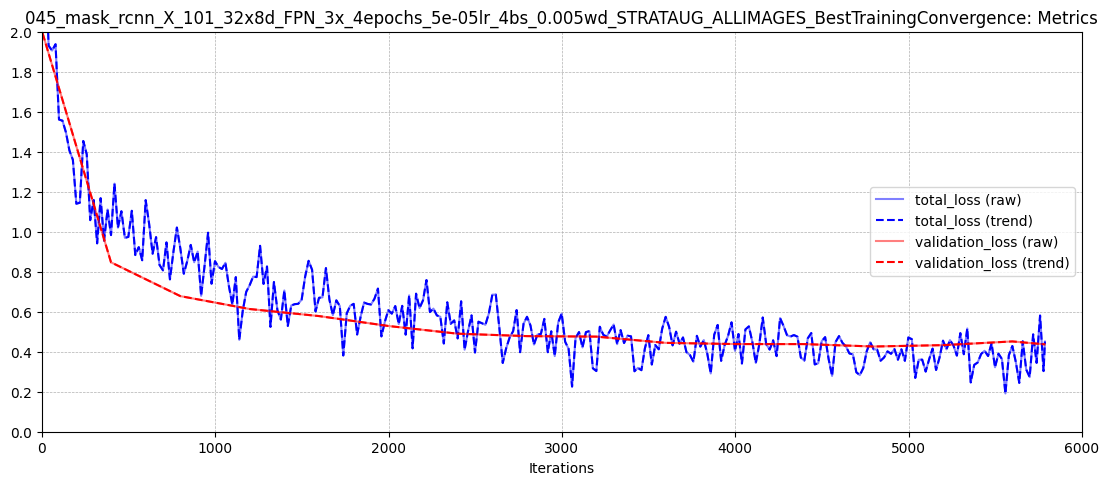

>>> saved plot to /content/drive/MyDrive/DLforPVFacades/paper/FinalCode/MaskRCNN/trained_models/045_mask_rcnn_X_101_32x8d_FPN_3x_4epochs_5e-05lr_4bs_0.005wd_STRATAUG_ALLIMAGES_BestTrainingConvergence/plots/loss_difference.png


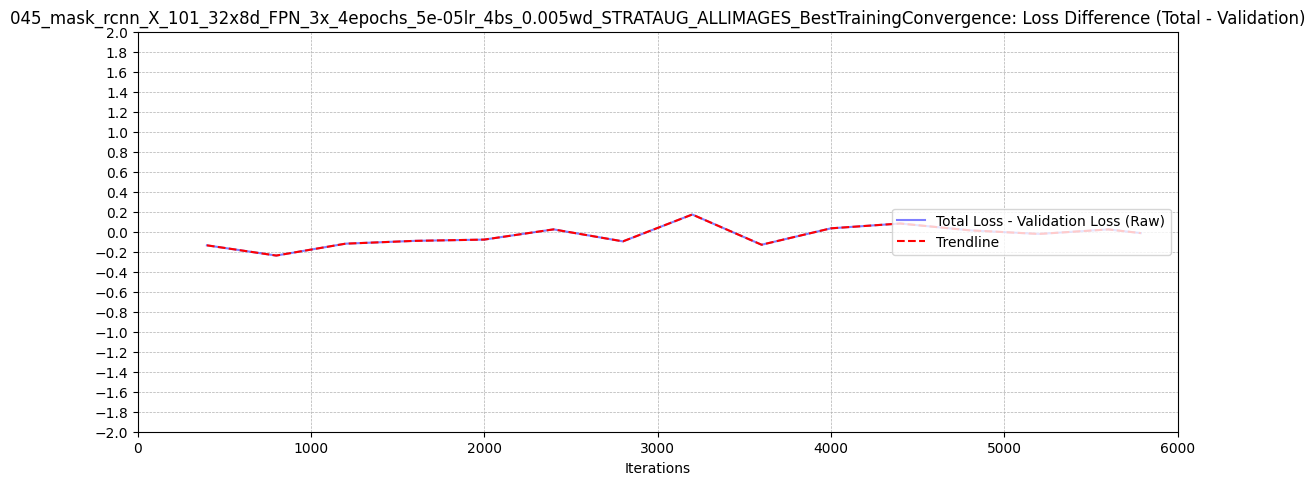

In [17]:
#@title plot learning

model_name = model_name_from_num(model_num)
model_dir = os.path.join(trained_models_folder, model_name)

reader = ResultReader(model_dir)

xlim= 6000

metrics = ['total_loss', 'validation_loss']
reader.plot_metrics(metrics, window_size= 1, xlim= xlim, ylim= 2, yticks= 0.2, save= True)
reader.plot_loss_difference(window_size= 1, xlim= xlim, ylim= 2, yticks= 0.2, save= True)

### Inference on Custom Images

In [ ]:
#@title predict PV on custom images
images_dir = os.path.join('/content/', "input")

if not os.path.exists(images_dir) or len(os.listdir(images_dir)) == 0:
    os.makedirs(images_dir, exist_ok= True)
    raise Exception("Load images into the 'input' folder.")

masks_dir = os.path.join(os.getcwd(), "output")
os.makedirs(masks_dir, exist_ok= True)

images = [item for item in os.listdir(images_dir) if item.endswith(".jpg") or item.endswith(".jpeg") or item.endswith(".png")]

print(f"Total image count {len(images)}")

model_num = 45
threshold = 0.85
plot = True

print(f"\n\n\n>>> PROCESSING model num {model_num}...")

model_name = model_name_from_num(model_num)
model_dir = os.path.join(trained_models_folder, model_name)
eval_folder = eval_folder
model_arch = "mask_rcnn_X_101_32x8d_FPN_3x"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(f"COCO-InstanceSegmentation/{model_arch}.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = model_dir
latest_pth = sorted([item for item in os.listdir(cfg.OUTPUT_DIR) if item.endswith('.pth')])[-1]
print(latest_pth)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


print(f"\n\n>>> PROCESSING threshold {threshold}...")


print(f"\n>>> threshold {threshold}")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
predictor = DefaultPredictor(cfg)

idx = 0
count = len(images)
count = min(count, len(images) - idx)
print(f"processing {count} images starting from {idx}...")

progbar = tqdm(total= len(images[idx:idx + count]))
for image in images:

    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)

    outputs = predictor(img)

    v1 = Visualizer(img[:, :, ::-1] * 0.1,
                metadata= metadata,
                scale= 1,
                instance_mode=ColorMode.IMAGE_BW
    )

    v2 = Visualizer(img[:, :, ::-1] * 0.1,
                metadata= metadata,
                scale= 1,
                instance_mode=ColorMode.IMAGE_BW
    )

    instances = outputs["instances"].to("cpu")

    out = v1.draw_dataset_dict(d)
    pred_img = v2.draw_instance_predictions(instances)
    bboxes_pred = instances.pred_boxes

    pred_count = len(bboxes_pred)

    # print(f">>> bounding boxes:")
    # print(f"gt\t{gt_count}")
    # print(f"pred\t{pred_count}\n")

    # UNIFY PRED MASKS INTO ONE (SHIFT TO SEMANTIC SEGMENTATION)
    if len(instances.pred_masks) > 0:
        pred_mask = np.logical_or.reduce(instances.pred_masks.numpy()).astype(int)
    else:
        pred_mask = np.zeros_like(img[:, :, 0], dtype=int)

    ''' VISUALIZE '''


    if plot:
        plt.figure(figsize=(11,8), constrained_layout= True)

        plt.subplot(1,2,1)
        plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        plt.imshow(img[:,:,::-1])
        plt.title(f"image: {image}")

        plt.subplot(1,2,2)
        plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
        plt.imshow(pred_img.get_image())
        plt.title(f"Model prediction mask")

        plt.show()

    progbar.update(1)
progbar.close()